### **Quick introduction to jupyter notebooks**
* Each cell in this notebook contains either code or text.
* You can run a cell by pressing Ctrl-Enter, or run and advance to the next cell with Shift-Enter.
* Code cells will print their output, including images, below the cell. Running it again deletes the previous output, so be careful if you want to save some results.
* You don't have to rerun all cells to test changes, just rerun the cell you have made changes to. Some exceptions might apply, for example if you overwrite variables from previous cells, but in general this will work.
* If all else fails, use the "Kernel" menu and select "Restart Kernel and Clear All Output". You can also use this menu to run all cells.
* A useful debug tool is the console. You can right-click anywhere in the notebook and select "New console for notebook". This opens a python console which shares the environment with the notebook, which let's you easily print variables or test commands.

### **Setup**

In [1]:
# Automatically reload modules when changed
%reload_ext autoreload
%autoreload 2
# Plot figures "inline" with other output
%matplotlib inline

# Import modules, classes, functions
from datetime import timedelta
from time import perf_counter as tic

from matplotlib import pyplot as plt
import numpy as np

from utils import plotDatasets, loadDataset, splitData, splitDataBins, getCVSplit, plotResultsCV, plotResultsDots, plotConfusionMatrixOCR
from evalFunctions import calcConfusionMatrix, calcAccuracy, calcAccuracyCM

# Configure nice figures
plt.rcParams['figure.facecolor']='white'
plt.rcParams['figure.figsize']=(8,5)

### ***! IMPORTANT NOTE !***

Your implementation should only use the `numpy` (`np`) module. The `numpy` module provides all the functionality you need for this assignment and makes it easier debuging your code. No other modules, e.g. `scikit-learn` or `scipy` among others, are allowed and solutions using modules other than `numpy` will be sent for re-submission. You can find everything you need about `numpy` in the official [documentation](https://numpy.org/doc/stable/).

### **1. Introduction**

The focus of this assignment is **supervised learning**. In particular, you will apply several machine learning algorithms to solve classification tasks. Throughout the three notebooks that consistute this assignment you will implement a kNN classifier, as well as single-layer and two-layer neural networks.

#### **1.1 Data**

Let's start by examining the datasets used in this assignments. Run the following cell to visualize the datasets.

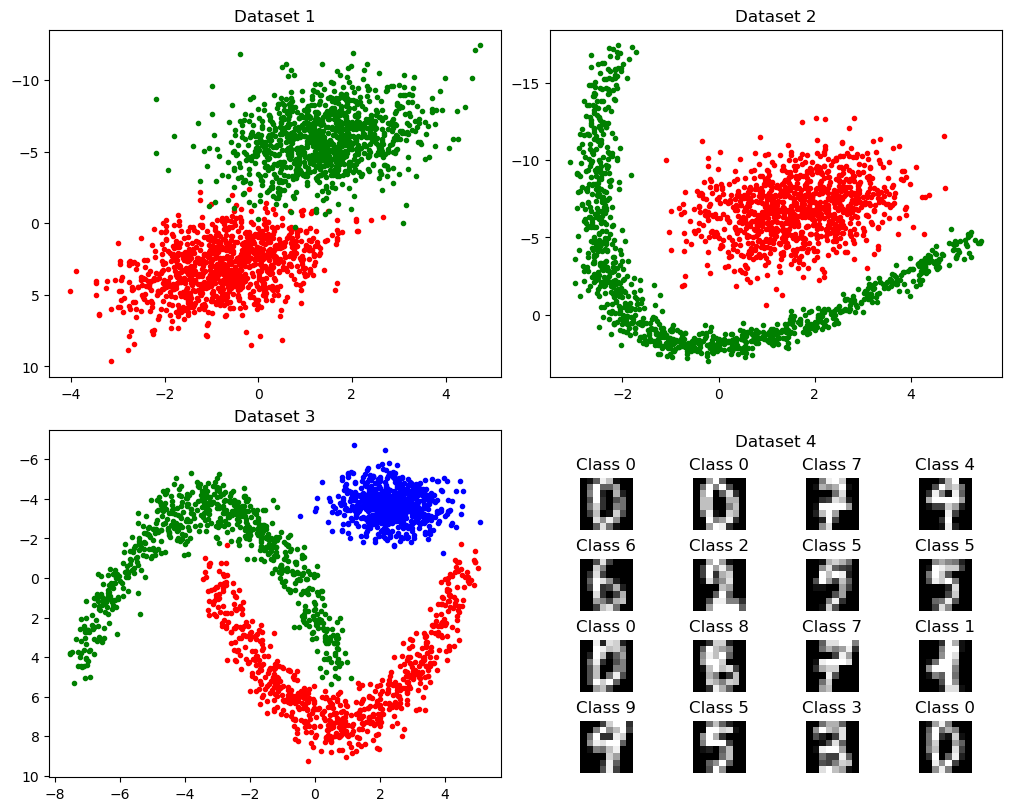

In [2]:
plotDatasets()

As you can see, datasets 1, 2 and 3 are point clouds with various shapes and number of classes, while dataset 4 consists of 8x8 pixel images of handwritten digits (these are stored as 64-length vectors). Each dataset in this assignment consists of three variables:
- `X` contains the input features for the data samples.
- `D` contains neural network target output values for the data samples. These are not used with kNN, and will be explained in the other notebooks in this assignment.
- `L` contains the class labels for the data samples.

Use the code in the next cell to load and examine all four datasets. Note that this assignment follows the convention that data samples are in the rows of a matrix, while features are in the columns.

In [3]:
datasetNr = 1
X, D, L = loadDataset(datasetNr)

print(f"X has shape {X.shape}")
print(f"D has shape {D.shape}")
print(f"L has shape {L.shape}")

X has shape (2000, 2)
D has shape (2000, 2)
L has shape (2000,)


#### **<span style="color:red">Question 1:</span>**
Describe all four datasets used in this assignment from a machine learning perspective:
- What does the dataset represent? What kind of data is it made of, and what can you tell about its arrangement?
- How many samples are in each dataset? How many features do they have?
- How many classes does each dataset have? What do they represent?
- Will the dataset require a linear or nonlinear classifier? Why?

#### **<span style="color:green">Answer:</span>**

**Dataset 1** : 
- 2 classes, clearly identifiable classes but some overlap. 
- 2000 samples, 2 features (x and y coordinates)
- This dataset require a linear classifier as we can see the two point-clouds can be linearly seperated.

**Dataset 2**
- 2 classes, two clearly identifiable classes with no overlap
- 2000 samples, 2 features (x and y coordinates)
- This dataset will require a non-linear classifier as it can be seen that on class is shape like a "C" and the other class is within that "C" shape"

**Dataset 3**
- 3 classes, no real overlpa between the classes
- 2000 samples, 2 features (x and y coordinates)
- This dataset will require a non-linear classifier as it can be seen that the 3 classes have complex shapes that are not seperables by strait lines.

**Dataset 4**
- 10 classes (digits from 0 to 9)
- 5620 samples, 64 features (8x8 pixels image)
- It is hard to tell if this dataset will require a linear or non-linear classifier as we cannot visualize the dataset in a 2D space. But it is more likely that we will need a non-linear classifier.


---
### **2. The kNN classifier**

k-nearest neighbors (kNN) is a relatively simple classification algorithm, that nevertheless can be quite effective. It is a nonlinear classifier where each new sample is assigned the class that most commonly appears among its neighbors in the training data, i.e. those training samples with the shortest distance to it. Distances in kNN can actually be defined in many different ways based on the application, but here we will use the most common Euclidean distance. The number of neighboring samples to consider, called k, is the only parameter of the algorithm. Depending on the specific properties of the problem, different values of k might give optimal results.

Unlike other types of classifiers, such as support vector machines and neural networks, kNN does not have any trainable parameters, and thus requires no training. It does, however, require a training dataset, which is effectively "memorized", and used as reference to classify all future data. This has the advantage of no training time, but results in slow inference times, which are proportional to the amount of training data.

#### **2.1 Implement the kNN algorithm**

The `kNN` function takes as input arguments the set of samples to be classified `X`, the number of neighbors to consider `k`, an the training samples `XTrain` and labels `LTrain`. There are different ways to implement the kNN algorithm, but we recommend you to follow these steps:

1. Calculate the Euclidean distances between every point in `X` and every point in `XTrain` and save them in a large matrix. Recall that the Eucliden distance between two $N$-dimensional points $\mathbf{x}$ and $\mathbf{y}$ is given as

$$ \large d = \sqrt{\sum_{i=1}^N (x_i - y_i)^2} .$$

Your implementation should not assume any specific number of features in the data, but should work for data of any number of features.

2. From each row of the matrix, select the `k` points with the smallest distance.

3. Find the class that appears most often among the `k` closest points and assign it to the corresponding point in `X`.

4. Sometimes there is a draw between two neighboring classes. Detect this and implement a strategy for choosing the class.

Keep in mind that, as was said previously, classifying data with kNN can be time-consuming, and an efficient implementation can really save you some time in the long run (especially once we implement cross-validation in section 3). Because of this, it is recommended that you try to avoid loops as much as possible, and instead take full advantage of `numpy`'s capacity for operating directly on arrays and [broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html) arrays. Some loops will likely be necessary, but you will see performance gains if you try to minimize their use.

In [4]:
def kNN(X, k, XTrain, LTrain):
    """ KNN
    Your implementation of the kNN algorithm.

    Args:
        X (array): Samples to be classified.
        k (int): Number of neighbors.
        XTrain (array): Training samples.
        LTrain (array): Correct labels of each sample.

    Returns:
        LPred (array): Predicted labels for each sample.
    """

    classes = np.unique(LTrain)
    nClasses = classes.shape[0]

    # --------------------------------------------
    # === Your code here =========================
    # --------------------------------------------
    
    # Calculate all the euclidean distances between X and XTrain
    distances = np.zeros((X.shape[0], XTrain.shape[0]))
    for i in range(X.shape[0]):
        for j in range(XTrain.shape[0]):
            distances[i, j] = np.sqrt(np.sum((X[i] - XTrain[j])**2))

    # Sort distances and find k closest labels
    kClosest = np.zeros((X.shape[0], k))
    for i in range(X.shape[0]):
        kClosest[i] = np.argsort(distances[i])[:k]
        

    # Find the most common label, store in LPred
    LPred = np.zeros(X.shape[0], dtype=int)
    for i in range(X.shape[0]):
        labels = LTrain[kClosest[i].astype(int)]
        LPred[i] = np.argmax(np.bincount(labels.astype(int)))
    
    # ============================================
    
    return LPred

#### **2.2 Test it on some data**

In order to test your implementation, you will first need to split the available data into training and test sets. You can then classify the test data using the training data as reference. Use the `splitData` function for this purpose.

In [5]:
# Select and load dataset
datasetNr = 1
X, D, L = loadDataset(datasetNr)

# Split data into training set (85%) and test set (15%)
XTrain, _, LTrain, XTest, _, LTest = splitData(X, D, L, 0.15)

Set a value for `k` and classify the training and test data.

In [6]:
# Set the number of neighbors
k = 5

# Classify training data
LPredTrain = kNN(XTrain, k, XTrain, LTrain)
# Classify test data
LPredTest  = kNN(XTest , k, XTrain, LTrain)

Calculate and print the training and test accuracies as well as the confusion matrix for the test data. For this to work, you first need to open the file `evalFunctions.py` and implement the functions `calcAccuracy`, `calcConfusionMatrix`, and `calcAccuracyCM`, based on the function descriptions.

In [7]:
# Calculate the training and test accuracy
accTrain = calcAccuracy(LPredTrain, LTrain)
accTest = calcAccuracy(LPredTest, LTest)
print(f"Train accuracy: {accTrain:.4f}")
print(f"Test accuracy: {accTest:.4f}")

# Calculate confunsion matrix of test data
confMatrix = calcConfusionMatrix(LPredTest, LTest)
print()
print("Test data confusion matrix:")
print(confMatrix)

accTestCM = calcAccuracyCM(confMatrix)
print()
print(f"Test accuracy from CM: {accTestCM:.4f}")

Train accuracy: 1.0000
Test accuracy: 1.0000

Test data confusion matrix:
[[157   0]
 [  0   0]]

Test accuracy from CM: 1.0000


Now we can use some plotting functions to examine the classified training and test data, as well as the decision boundaries that separate the various classes. We will use these types of visualizations for all three classifier types.

For datasets 1-3 you will see classification results for the training and test data, where correctly classified samples appear in green and incorrectly classified samples appear in red. The backgrounds of these plots show in grayscale colors the different regions of the feature space which are assigned each class by the classifier. This is especially useful in order to examine the shape of the decision boundaries.

For the dataset 4 you will see a plot that shows examples of each type of correct and incorrect classification as given by the confusion matrix.

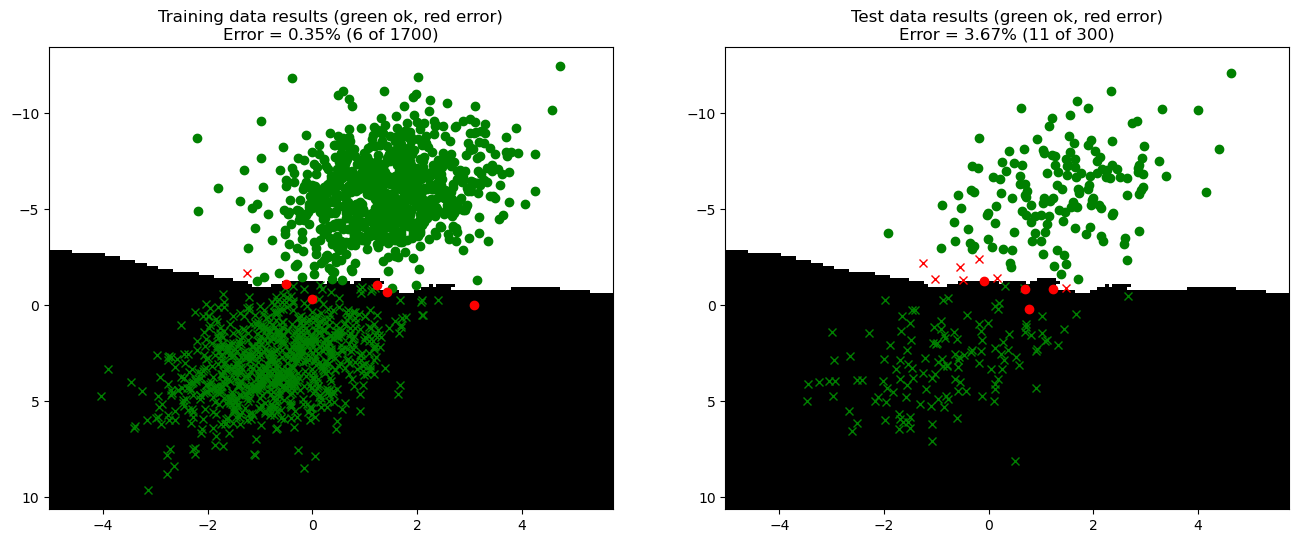

In [8]:
if datasetNr < 4:
    plotResultsDots(XTrain, LTrain, LPredTrain, XTest, LTest, LPredTest, lambda X: kNN(X, k, XTrain, LTrain))
else:
    plotConfusionMatrixOCR(XTest, LTest, LPredTest)

#### **<span style="color:red">Question 2:</span>**
- Describe how your kNN implementation works, step by step.
- Describe the way in which your implementation handles ties in the neighbor classes, that is, situations in which several classes are equally common among the neighbors of a point. For example, `k=4` and the classes of the neighbors are `[0,0,1,1]`, or `k=5` and the classes are `[1,1,2,3,3]`.

#### **<span style="color:green">Answer:</span>**

**How our implementaion works**
- First we calculates the distance from any point to every other point and store it in a matrix.
- Secondly we find the k-closest points to any point by sorting our distance matrix. 
- Finally, we predict our label based on the majority of labels in the k-closest points. 

**How does the implementation handles ties in the neighbor classes**

 We use the np.argmax function to determine the majority class. According to the documentation of that function, in case of a tie, the function return the first occurence of the majority class.
 
 "In case of multiple occurrences of the maximum values, the indices corresponding to the first occurrence are returned."

#### **2.3 Try kNN on all datasets**

Once you have made sure that your kNN implementation works correctly, we can define a function that performs all of the previous steps: it loads data, trains and evaluates a kNN on a specific dataset using your own kNN implementation, and prints the results. You can use it to experiment with applying your kNN implementation on all the datasets. Try experimenting with different values of `k` and note especially the effect that it has on the decision boundaries.

In [9]:
def runkNNOnDataset(datasetNr, testSplit, k):
    X, D, L = loadDataset(datasetNr)
    XTrain, _, LTrain, XTest, _, LTest = splitData(X, D, L, testSplit)

    LPredTrain = kNN(XTrain, k, XTrain, LTrain)
    LPredTest = kNN(XTest, k, XTrain, LTrain)
    
    accTrain = calcAccuracy(LPredTrain, LTrain)
    accTest = calcAccuracy(LPredTest, LTest)
    confMatrix = calcConfusionMatrix(LPredTest, LTest)
    
    print(f'Train accuracy: {accTrain:.4f}')
    print(f'Test accuracy: {accTest:.4f}')
    print("Test data confusion matrix:")
    print(confMatrix)

    if datasetNr < 4:
        plotResultsDots(XTrain, LTrain, LPredTrain, XTest, LTest, LPredTest, lambda X: kNN(X, k, XTrain, LTrain))
    else:
        plotConfusionMatrixOCR(XTest, LTest, LPredTest)

Train accuracy: 1.0000
Test accuracy: 1.0000
Test data confusion matrix:
[[128   0]
 [  0   0]]


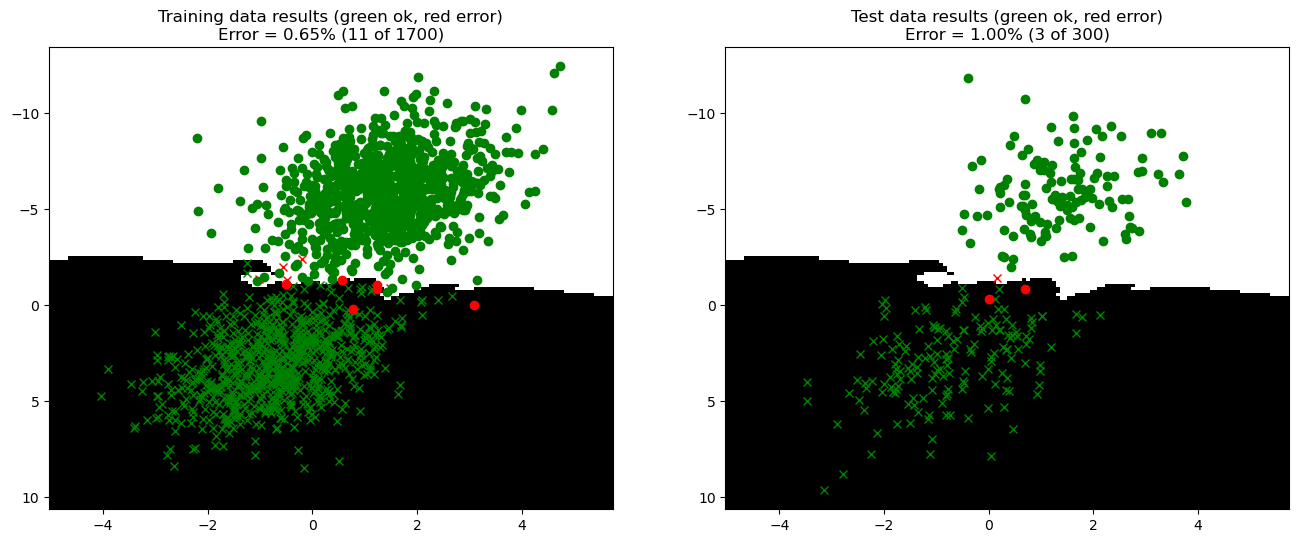

In [10]:
runkNNOnDataset(1, testSplit=0.15, k=5)

Train accuracy: 1.0000
Test accuracy: 1.0000
Test data confusion matrix:
[[144   0]
 [  0   0]]


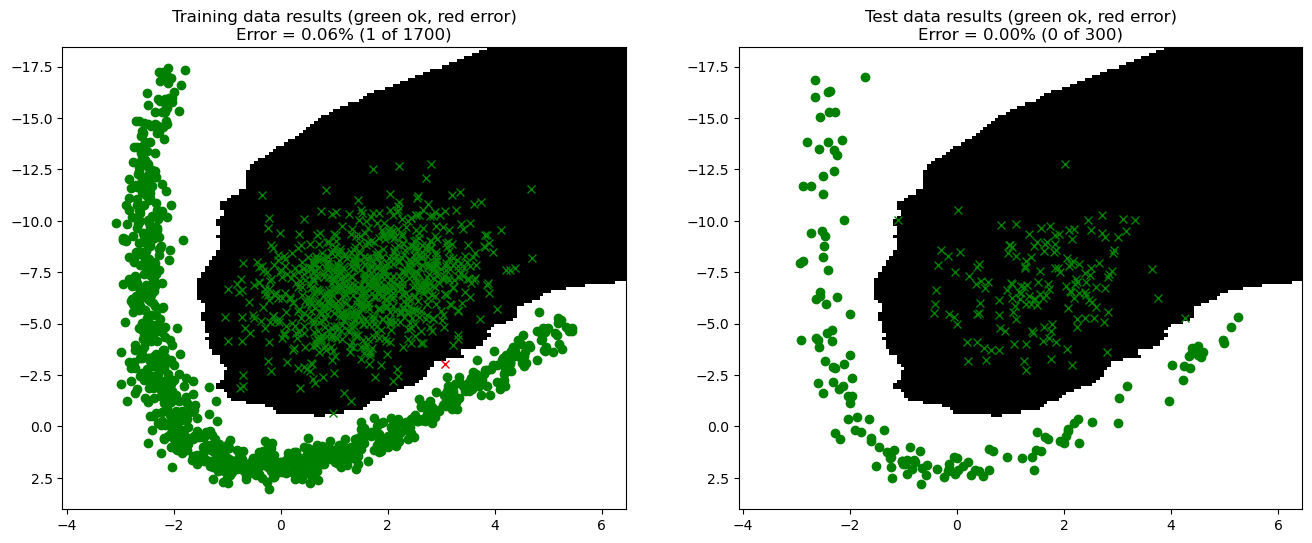

In [11]:
runkNNOnDataset(2, testSplit=0.15, k=3)

Train accuracy: 1.0000
Test accuracy: 1.0000
Test data confusion matrix:
[[107   0   0]
 [  0  94   0]
 [  0   0   0]]


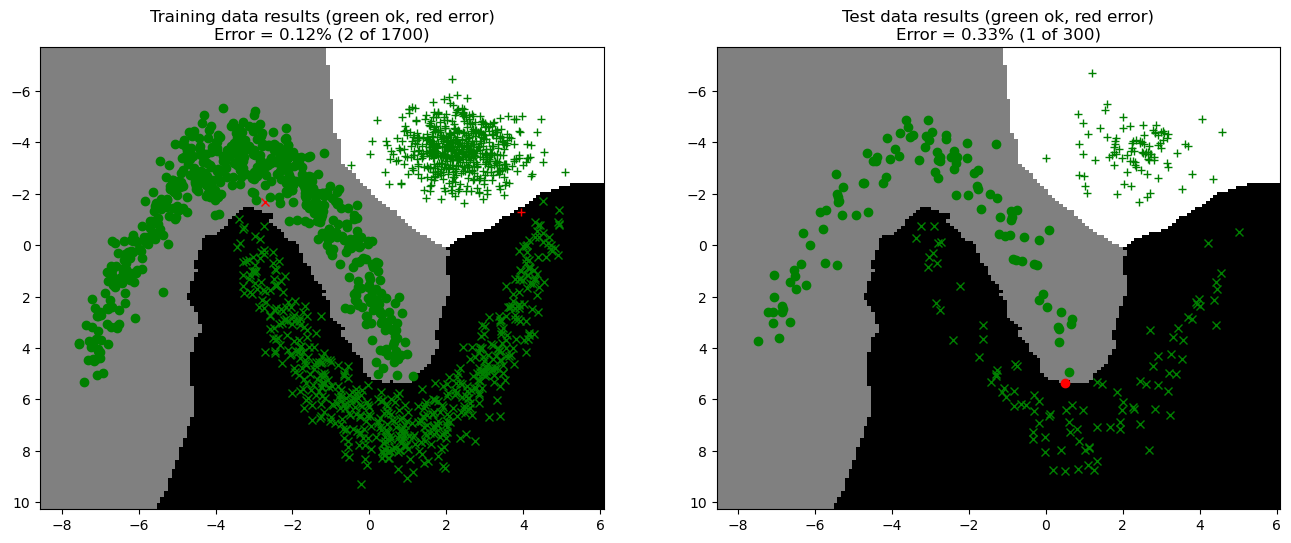

In [12]:
runkNNOnDataset(3, testSplit=0.15, k=3)

Train accuracy: 1.0000
Test accuracy: 0.9780
Test data confusion matrix:
[[430   0   1   0   0   0   1   0   1   0]
 [  1 417   1   0   0   0   1   3   0   0]
 [  1   0 425   0   1   0   1   2   4   0]
 [  1   0   0 420   0   1   2   0   2   0]
 [  0   0   4   1 410   1   0   1   3   0]
 [  1   0   0   0   0 409   0   1   0   0]
 [  0   0   0   1   0   0 430   1   1   0]
 [ 14   0   0   2   0   0   0 392   2   0]
 [  5   0   4   5   7   0   2   4 398   0]
 [  0   0   0   0   0   0   0   0   0   0]]


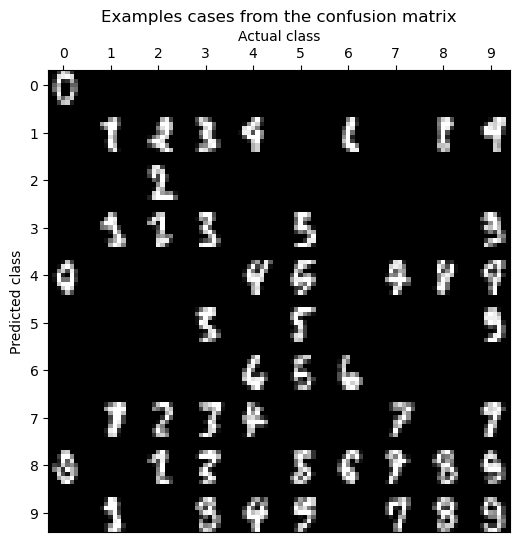

In [13]:
runkNNOnDataset(4, testSplit=0.75, k=1)

### **3. Cross-validation**

As mentioned previously, different values of `k` might work better or worse for each dataset. However, in order to establish which value is best for each dataset it is not enough to run kNN once for each `k` and select the one that gives the highest accuracy. This approach would not take into account the variations in performance that result from the random splitting of training and test data. Results obtained in this way will not reflect the performance that can be expected when the algorithm is applied on new data.

In order to thoroughly test which value of `k` is best we can resort to cross-validation methods, which rely on repeatedly testing the model on different splits of the data in order to assess its generalization performance. In particular, we will focus on n-fold cross-validation. In this method, we will first reserve a portion of the data for testing, `XTest`, which we will not touch until the very end, and use the remaining data `XTrain` for cross-validation. `XTrain` will again be split into `N` bins, which corresponds with the number of times that the kNN algorithm will be run for each value of `k`. For each iteration, one bin is used as validation data `XValCV`, and all the remaining bins are combined and used as training data `XTrainCV`. This will result in `N` accuracies for each value of `k`, which we will average to obtain the **average cross-validation accuracy**, which is the relevant metric for determining the optimal `k`. The higher the value of `N`, the more precise will be our determination of the accuracy of different values of `k`. This picture illustrates 3-fold cross validation for one value of `k`.

![](NotebookMaterial/CrossValidation.png)

After determining the value of `k` that gives the highest accuracy, we will use it to classify `XTest` using all of `XTrain` as reference data. This will give as the **test accuracy** of our model, and is the definitive metric representing its performance.

Start by splitting the available data into training and test `splitData` function as before. Then, use the function `splitDataBins` to further split the training data into `N` bins. Finally, use the funciton `getCVSplit` to combine the data bins into `XTrainCV` and `XValCV`. This function takes in the degree of cross validation `N` and the current iteration of the cross validation `i`, indicating which bin will be used for the validation data (note that this is zero-indexed). Three-fold cross-validation should be a minimum, but do not be afraid to try using more bins, e.g. 50-100, as the resulting inference time increases less than linearly.

In [14]:
# Select and load dataset
datasetNr = 1
X, D, L = loadDataset(datasetNr)

# Split data into training and test sets
XTrain, _, LTrain, XTest, _, LTest = splitData(X, D, L, 0.15)

# Select the number of bins to split the data
nBins = 50

# Split data into bins based on the settings above
# The outputs are lists of length nBins, where each item is a data array. Try printing for example XBins[0].shape.
XBins, _, LBins = splitDataBins(XTrain, None, LTrain, nBins)

Finish the implementation of the `crossValidation` function, which needs to take a maximum value of `k` and the cross validation bins and return a matrix containing the cross-validation accuracies obtained for different values of `k` and combinations of bins used for training.

In [15]:
def crossValiation(kMax, XBins, LBins):
    """Performs cross-validation using kNN

    Args:
        kMax (int): Maximum value of k to test. Values used will be [1-kMax].
        XBins (list of arrays): Training+validation data samples.
        LBins (list of arrays): Training+validation data labels.

    Returns:
        meanAccs (array): Cross-validation accuracies. Bins are in the rows, and
            values of k in the columns.
        kBest (int): Optimal value of k based on cross validation results.
    """

    nBins = len(XBins)
    accs = np.zeros((nBins, kMax))

    # This is used to show the progress
    timeStart = tic()

    # --------------------------------------------
    # === Your code here =========================
    # --------------------------------------------
    
    for b in range(nBins):

        # Use getCVSplit to combine bins for training and validation data
        XTrain, _, LTrain, XVal, _, LVal = getCVSplit(XBins,None, LBins,nBins, b)
        
        for k in range(kMax):

            # Classify validation data using kNN
            kNNPred = kNN(XVal, k+1, XTrain, LTrain)
            
            # ... and store resulting accuracy in the accs matrix

            accs[b, k] = calcAccuracy(kNNPred, LVal)
            
            # Print progress and remaining time
            timeLeft = round((tic()-timeStart)*( nBins*kMax / (b*kMax + k + 1) - 1))
            etaStr = str(timedelta(seconds=timeLeft))
            print(f"b: {b+1:2}, k: {k+1:2}, ETA: {etaStr}    ", end="\r")
    
    # Compute the mean cross validation accuracy for each k
    meanAccs = np.mean(accs, axis=0)
    
    # And find the best k
    kBest = np.argmax(meanAccs) + 1
    
    # ============================================
    
    return meanAccs, kBest

Test your cross-validation implementation and look at the resulting performance plot. This shows the average cross-validation accuracy for all the values of `k` tested.

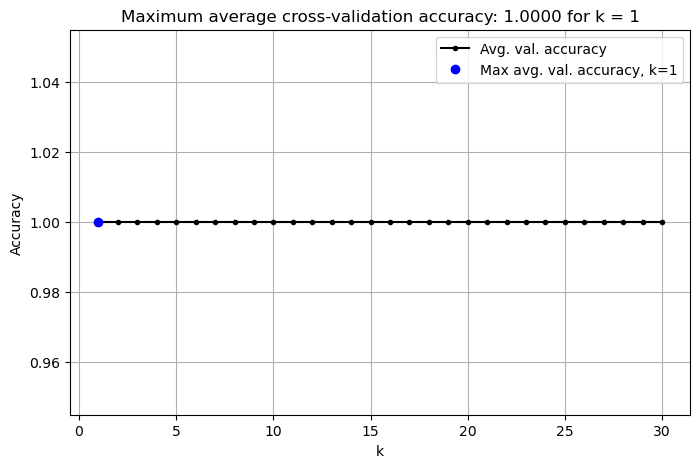

In [16]:
meanAccs, kBest = crossValiation(30, XBins, LBins)
plotResultsCV(meanAccs, kBest)

After selecting the optimal value of `k` using cross-validation, use this value to classify `XTest` using the data in `XTrain` as reference to obtain the test accuracy.

In [17]:
LPredTest = kNN(XTest, kBest, XTrain, LTrain)

confMatrix = calcConfusionMatrix(LPredTest, LTest)
acc = calcAccuracy(LPredTest, LTest)

print(f"Test accuracy: {acc:.4f}")
print("Test data confusion matrix:")
print(confMatrix)

Test accuracy: 1.0000
Test data confusion matrix:
[[143   0]
 [  0   0]]


#### **<span style="color:red">Question 3:</span>**
- Describe how you implemented cross-validation.

#### **<span style="color:green">Answer:</span>**

**How does our cross-validation implementation works**
- Our implementation depends on 2 hyper parameters : the number of bins B and max_K 
- The number of bins determines the number of cross-validation to be computed. The dataset is seperated into B bins. Then we run B iterations where we take each successive bin as the validation data, and the other bins as the training data. In each of those iterations we compute our kNN algorithm for each k between 1 and max_K. at the end of each kNN we compute the accuracy and store it. After we have done this for each cross-validation, we can compute the mean accuracy for each K, based on all the cross-validation runs, and we found the optimal K by finding the highest mean.

---
### **4. Cross validation for all datasets**

Once again we define a single function that performs all of the previous cross-validation for a given dataset and shows the results. Use it to perform cross-validation on all four datasets.

In [18]:
def runkNNCrossValidationOnDataset(datasetNr, testSplit, nBins, kMax):
    X, D, L = loadDataset(datasetNr)
    XTrain, _, LTrain, XTest, _, LTest = splitData(X, D, L, testSplit)
    XBins, _, LBins = splitDataBins(XTrain, None, LTrain, nBins)

    meanAccs, kBest = crossValiation(kMax, XBins, LBins)
    plotResultsCV(meanAccs, kBest)

    LPredTrain = kNN(XTrain, kBest, XTrain, LTrain)
    LPredTest = kNN(XTest, kBest, XTrain, LTrain)
    confMatrix = calcConfusionMatrix(LPredTest, LTest)
    accTest = calcAccuracy(LPredTest, LTest)

    print(f'Test accuracy: {accTest:.4f}')
    print("Test data confusion matrix:")
    print(confMatrix)

    if datasetNr < 4:
        plotResultsDots(XTrain, LTrain, LPredTrain, XTest, LTest, LPredTest, lambda X: kNN(X, kBest, XTrain, LTrain))
    else:
        plotConfusionMatrixOCR(XTest, LTest, LPredTest)
        

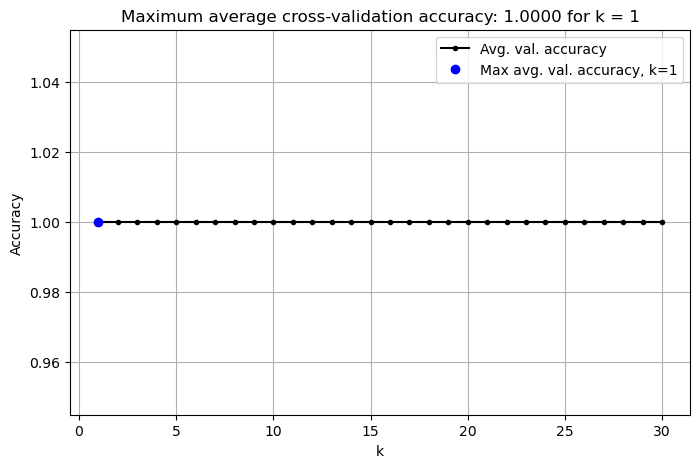

Test accuracy: 1.0000
Test data confusion matrix:
[[155   0]
 [  0   0]]


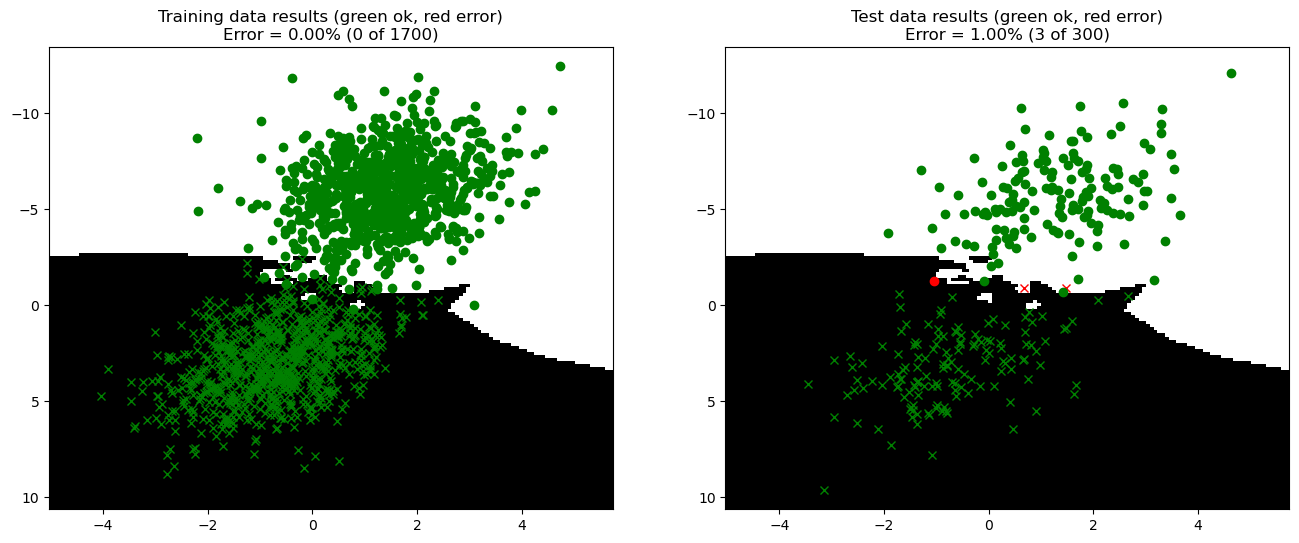

In [19]:
runkNNCrossValidationOnDataset(1, testSplit=0.15, nBins=20, kMax=30)

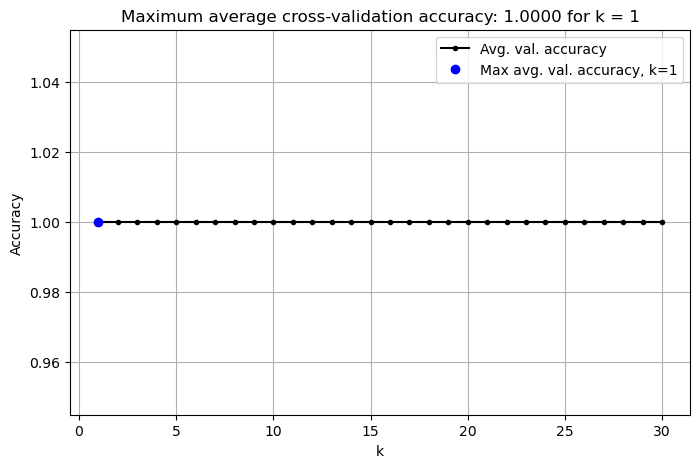

Test accuracy: 1.0000
Test data confusion matrix:
[[166   0]
 [  0   0]]


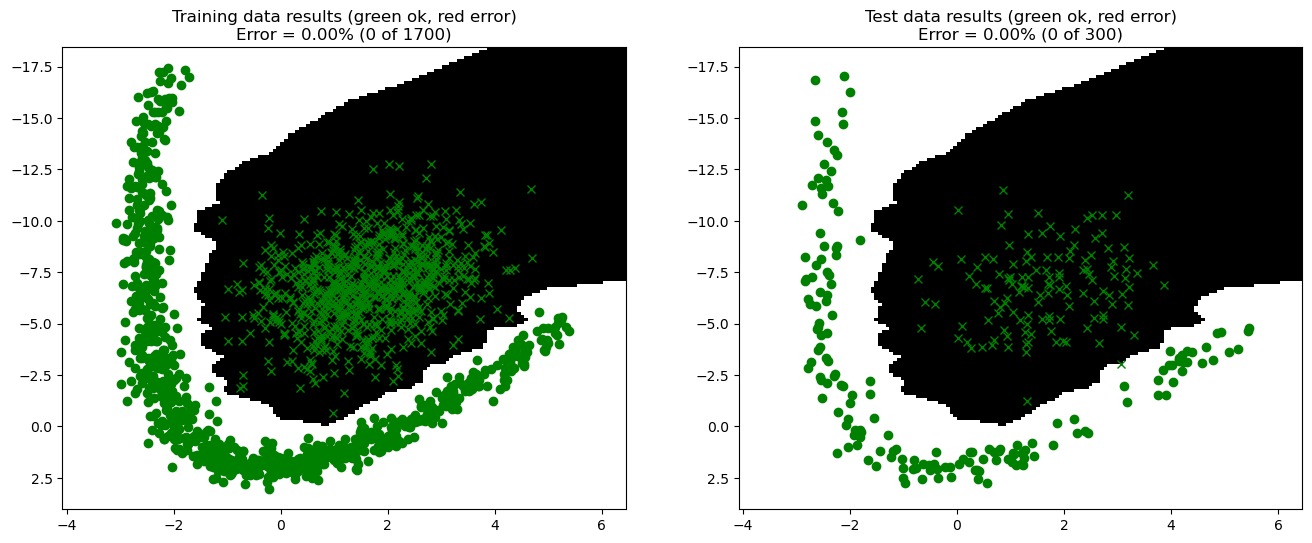

In [20]:
runkNNCrossValidationOnDataset(2, testSplit=0.15, nBins=20, kMax=30)

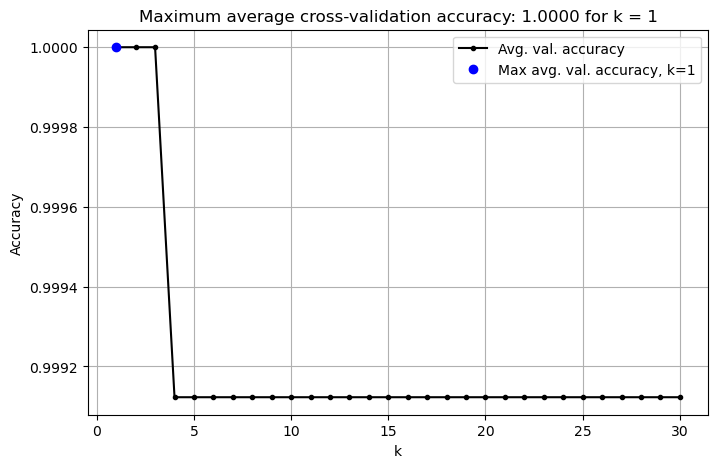

Test accuracy: 1.0000
Test data confusion matrix:
[[110   0   0]
 [  0  96   0]
 [  0   0   0]]


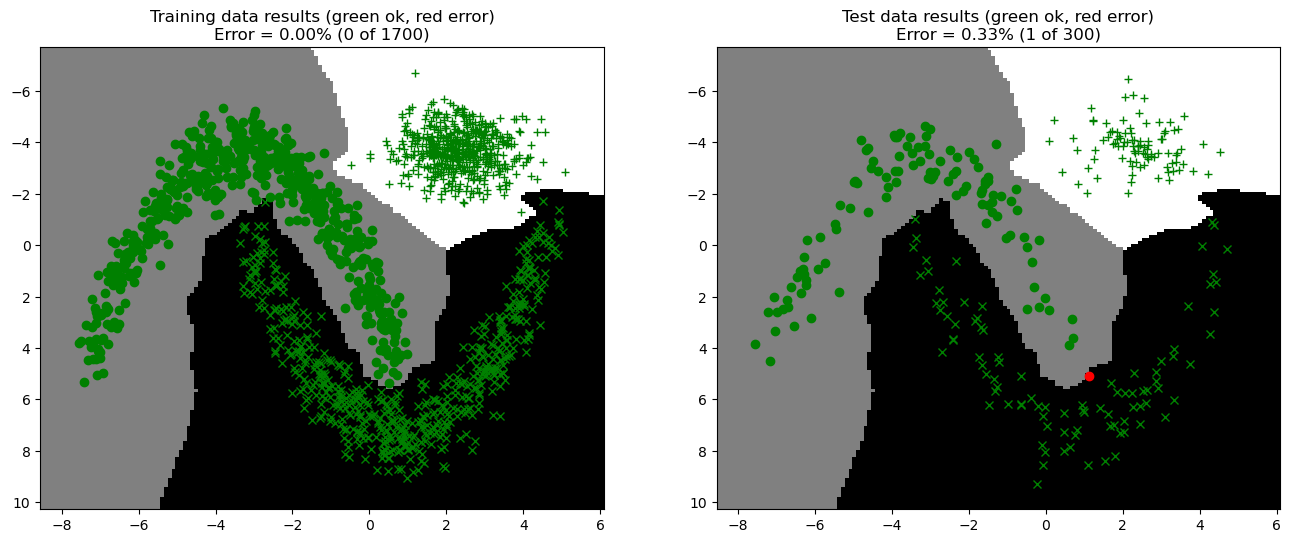

In [21]:
runkNNCrossValidationOnDataset(3, testSplit=0.15, nBins=20, kMax=30)

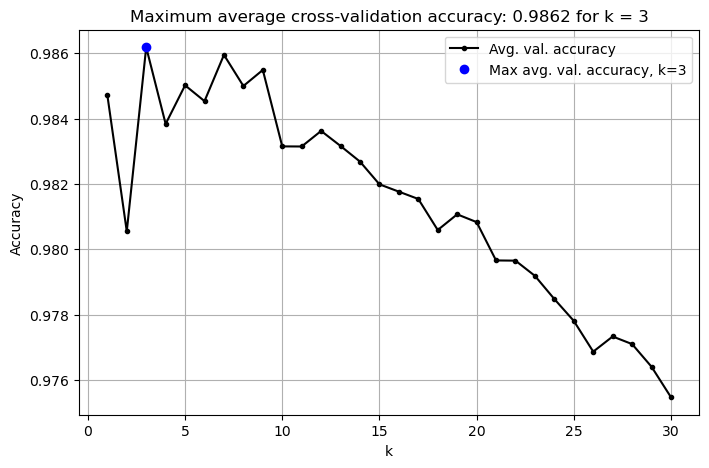

Test accuracy: 0.9909
Test data confusion matrix:
[[82  0  0  0  0  0  1  0  0  0]
 [ 0 92  0  0  0  0  0  0  0  0]
 [ 0  0 72  0  0  0  0  0  0  0]
 [ 1  0  0 84  0  1  0  0  0  0]
 [ 0  0  0  0 83  0  0  0  1  0]
 [ 0  0  0  0  0 78  0  0  0  0]
 [ 0  0  0  0  0  0 86  0  0  0]
 [ 2  0  1  0  0  0  0 98  0  0]
 [ 0  0  0  0  0  0  0  0 86  0]
 [ 0  0  0  0  0  0  0  0  0  0]]


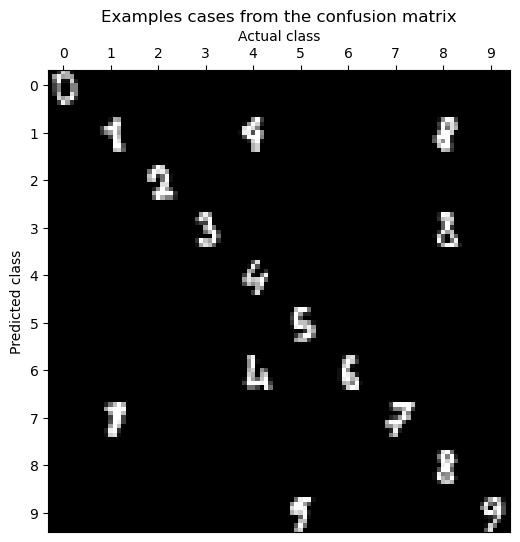

In [22]:
runkNNCrossValidationOnDataset(4, testSplit=0.15, nBins=20, kMax=30)

#### **<span style="color:red">Question 4:</span>**
- Comment on the results for each dataset. What is the optimal k, and are those results reasonable?

#### **<span style="color:green">Answer:</span>**

\[ Your answers here \]

---
### **5. Optional task**

In section 2 in this notebook, where you first implemented the kNN algorithm, we said that "some loops will be necessary" in the implementation. *This is actually not true*. By rewriting the computation of the Euclidean distance in a clever way, and using the full capabilities of numpy broadcasting, it is possible to compute the distance matrix without a single loop. This solution is incredibly fast and therefore enables high degree cross validation over many values of k. Your optional task is to rewrite your implementation to have no loops, and to rerun the cross validation.

#### **<span style="color:red">Question 5:</span>**
- How much faster is the new implementation? You can time the execution of a code cell by putting the magic command (yes, that is the official name) `%%timeit -n1 -r1` on the first row of the cell. Note that the double percentages are part of the command.

#### **<span style="color:green">Answer:</span>**

\[ Your answers here \]